In [29]:
import sys
sys.path.append("..")
from src.model import *
from src.Utils_simulations import *
from src.Utils_study_results import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
########################################################
# Récuperation des données de simulation pour l'étude des résultats
########################################################

date_debut = "2022-01-01"
date_fin = "2025-01-01"

nb_iterations_list = [i for i in range(75, 1000,50)] 
nb_mois_entrainements_list = [3,6,12]
sentiment_cols = [
    'SENTIMENT_VADER',
    'SENTIMENT_FinancialBERT-Sentiment-Analysis',
    'SENTIMENT_distilroberta-finetuned-financial-news-sentiment-analysis',
    'SENTIMENT_deberta-v3-ft-financial-news-sentiment-analysis'
]

simulation_download_results(date_debut, date_fin, nb_iterations_list, nb_mois_entrainements_list, sentiment_cols)

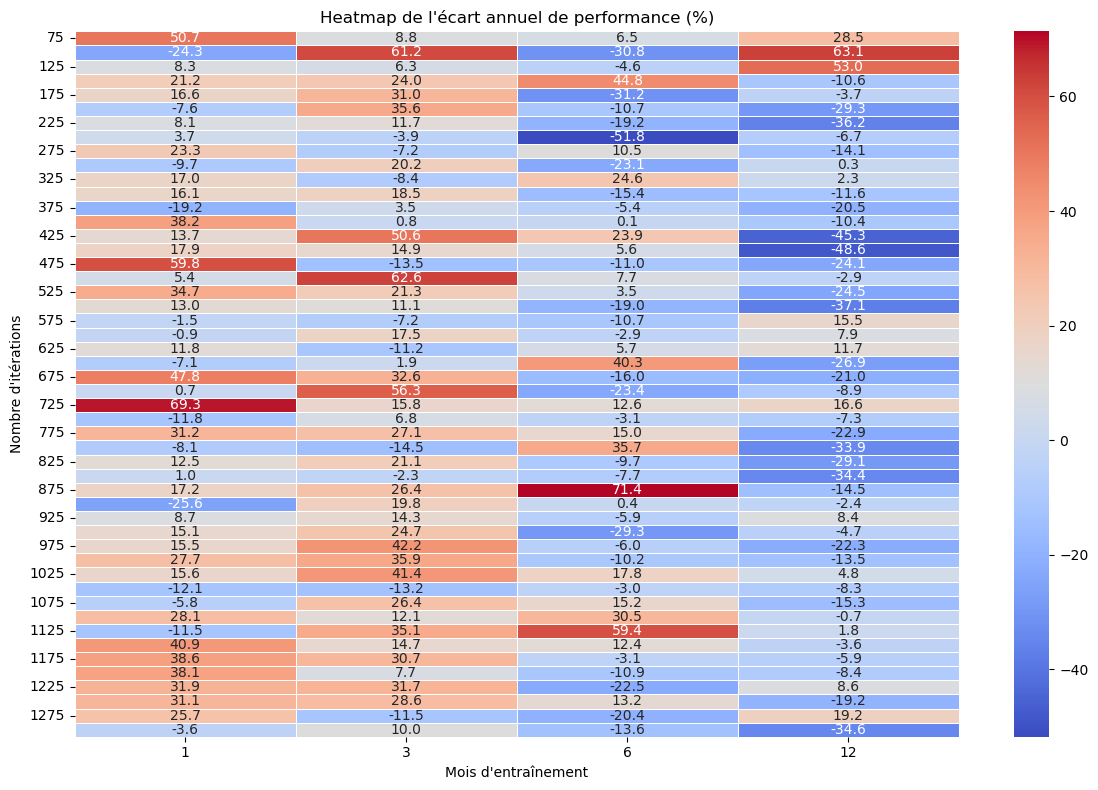

In [ ]:
# Charger les résultats
df = pd.read_csv("df_global/resultats_global.csv")

# Heatmap : Écart annuel de performance
pivot_ecart = df.pivot(index='nb_iterations', columns='nb_mois_entrainement', values='Écart annuel de performance (%)')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_ecart, annot=True, fmt=".1f", cmap="coolwarm", linewidths=.5)
plt.title("Heatmap de l'écart annuel de performance (%)")
plt.xlabel("Mois d'entraînement")
plt.ylabel("Nombre d'itérations")
plt.tight_layout()
plt.show()


### Analyse de la heatmap :

- Une surperformance marquante est observée à **100 itérations et 12 mois d’entraînement** (+63,1 %), ce qui constitue le **meilleur score** relevé sur la carte.
- D’autres combinaisons offrent également de très bons résultats :
  - 500 itérations / 3 mois (+62,6 %)
  - 700 itérations / 3 mois (+56,3 %)
  - 1000 itérations / 3 mois (+35,9 %)
- Les **périodes d'entraînement courtes** (notamment 1 et 3 mois) présentent **des performances régulièrement positives**, avec plusieurs zones chaudes dans la heatmap.
- À l'inverse, certaines combinaisons entraînent **des pertes significatives** :
  - 250 itérations / 6 mois (–51,8 %)
  - 450 itérations / 12 mois (–48,6 %)
  - 100 itérations / 6 mois (–30,8 %)
- Globalement, la période de **12 mois tend à sous-performer**, ce qui peut être lié à un **effet de surapprentissage** ou à une **désynchronisation avec les régimes de marché récents**.

---

### Conclusion intermédiaire :
Les durées d'entraînement de **1 à 3 mois** ressortent comme les plus performantes, probablement parce qu'elles permettent une meilleure adaptation aux dynamiques de marché récentes.

---

### Limite de l’indicateur utilisé :
L'indicateur utilisé ici (écart annuel de performance, i.e. rendement total annualisé) **tend à amplifier certaines variations**, ce qui peut donner une vision biaisée des performances réelles. Un indicateur basé sur le **rendement moyen journalier ou mensuel** serait sans doute plus représentatif.

---

### Vers une évaluation plus rigoureuse :

La suite de l’analyse reposera sur **l’écart moyen entre le rendement journalier du modèle et celui d’une stratégie passive “buy and hold”**.

#### Rappel sur la stratégie "buy and hold" :
Il s'agit d'une stratégie qui consiste à **acheter l'actif en début de période** et à le conserver sans intervention jusqu'à la fin. Elle constitue une **référence passive standard** pour évaluer si une stratégie active, comme celle basée sur les signaux de sentiment, produit une **valeur ajoutée significative**.

En comparant les rendements journaliers moyens du modèle à ceux du buy and hold, on évaluera **plus précisément sa capacité à générer de la valeur quotidiennement**, et non seulement sur des périodes agrégées.


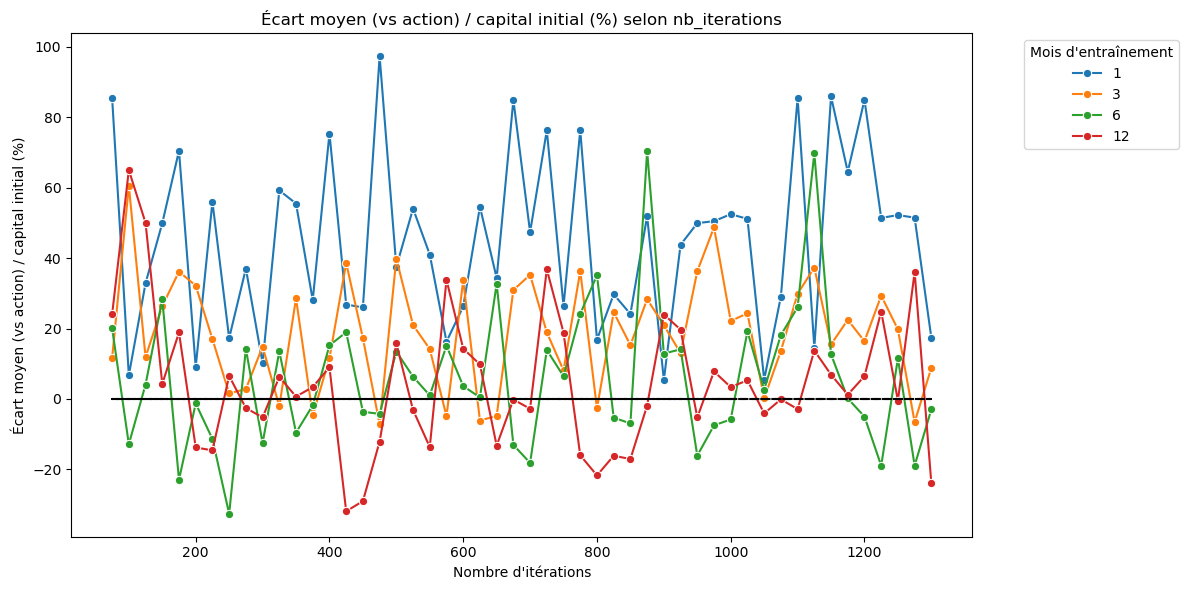

In [40]:
# Courbe : Écart moyen (vs action) / capital initial (%) selon nb_iterations
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='nb_iterations', y='Écart moyen (vs action) / capital initial (%)', hue='nb_mois_entrainement', palette='tab10', marker='o')
plt.plot(df['nb_iterations'], [0] * len(df['nb_iterations']), color='black', linestyle='--')
plt.title("Écart moyen (vs action) / capital initial (%) selon nb_iterations")
plt.xlabel("Nombre d'itérations")
plt.ylabel("Écart moyen (vs action) / capital initial (%)")
plt.legend(title="Mois d'entraînement", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Interprétation rapide :

- **1 mois** : Surperformance systématique malgré une volatilité élevée.
- **3 mois** : Bonne performance avec stabilité accrue.
- **6 mois** : Très instable, peu prévisible.
- **12 mois** : Globalement peu performant, effet de lissage excessif probable.

Pour approfondir, un barplot avec intervalle de confiance à 95 % est présenté ci-dessous.


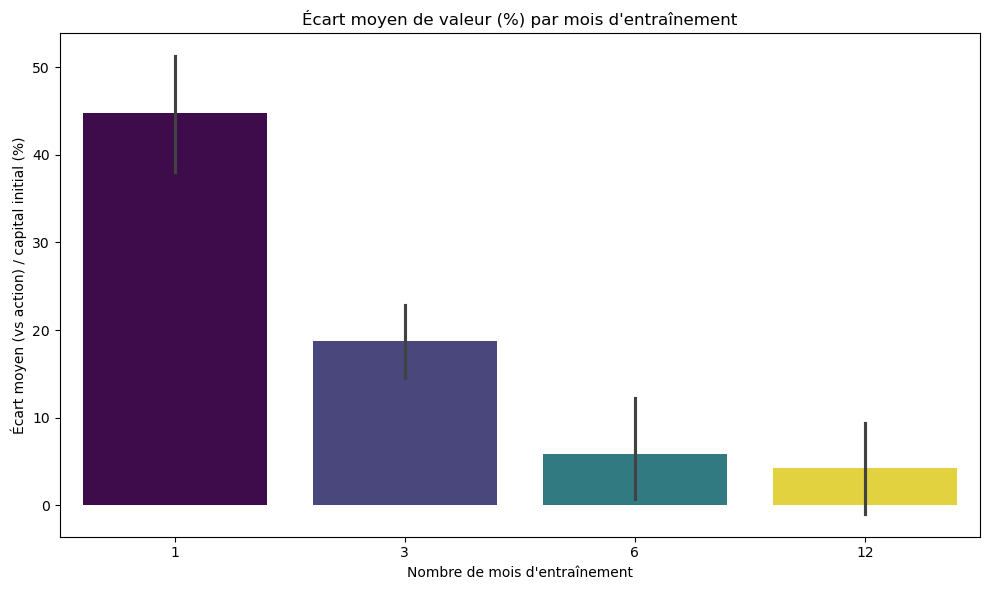

Le meilleur écart moyen avec l'action est de 44.75% pour un entraînement sur 1 mois.


In [41]:

# Barplot : Écart moyen de valeur vs action par nb_mois_entrainement
plt.figure(figsize=(10, 6))
df_bar = df.groupby('nb_mois_entrainement')['Écart moyen (vs action) / capital initial (%)'].mean().reset_index()
sns.barplot(data=df, x='nb_mois_entrainement', y='Écart moyen (vs action) / capital initial (%)', palette='viridis',hue='nb_mois_entrainement',errorbar=('ci', 95),legend=False)
plt.title("Écart moyen de valeur (%) par mois d'entraînement")
plt.xlabel("Nombre de mois d'entraînement")
plt.ylabel("Écart moyen (vs action) / capital initial (%)")
plt.tight_layout()
plt.show()

# 🔍 Conclusion automatique
best_row = df_bar.loc[df_bar['Écart moyen (vs action) / capital initial (%)'].idxmax()]
best_mois = int(best_row['nb_mois_entrainement'])
best_val = round(best_row['Écart moyen (vs action) / capital initial (%)'], 2)

print(f"Le meilleur écart moyen avec l'action est de {best_val}% pour un entraînement sur {best_mois} mois.")


### Lecture du barplot (écart moyen vs action) :

| Durée d’entraînement | Moyenne (%) | Intervalle 95 % (±1,96σ) | Conclusion rapide |
|----------------------|-------------|--------------------------|-------------------|
| 1 mois               | ≈ 45 %      | 38 % à 52 %              | Meilleure surperformance, forte dispersion |
| 3 mois               | ≈ 19 %      | 14 % à 24 %              | Bonne stabilité, alternative équilibrée |
| 6 mois               | ≈ 6 %       | 0 % à 12 %              | Incertain, intervalle inclut zéro |
| 12 mois              | ≈ 4 %       | –1 % à 10 %               | Négligeable statistiquement |

---

### Points clés complémentaires :

- **Confirmation** : 1 mois est le plus optimal mais avec plus de variations, 3 mois offre un compromis interessant entre stabilité et performance.
- Au-delà de 3 mois, l'intérêt diminue rapidement.
- À 12 mois, aucune surperformance nette.

**Limitation à noter** :  
En raison du temps de calcul élevé, l'analyse a été volontairement restreinte aux durées d'entraînement de 1, 3, 6 et 12 mois. Ce choix permet de conserver une bonne représentativité des résultats tout en rendant l'étude techniquement réalisable.


---

### Conclusion globale :

La visualisation renforce l’idée que **des périodes d’entraînement courtes (1 à 3 mois) maximisent la surperformance moyenne** par rapport à l'action de référence. Les périodes plus longues montrent des limites claires dues au surapprentissage ou à une perte d'adaptabilité aux contextes récents.


### **Analysons en profondeur les performances pour un mois d'entrainement selon le nombre d'itérations**


In [ ]:
# Charger les résultats
df = pd.read_csv("df_global/resultats_global_mois_1.csv")

# Conversion des colonnes numériques
cols_to_float = [
    'Rendement total (%)',
    'Rendement annualisé (%)',
    'Volatilité annualisée (%)',
    'Max Drawdown (%)',
    'Écart annuel de performance (%)',
    'Écart moyen (vs action) / capital initial (%)'
]
df[cols_to_float] = df[cols_to_float].apply(pd.to_numeric, errors='coerce')

### Évolution des performances pour 1 mois d'entraînement selon le nombre d’itérations

Afin d'étudier la stabilité du modèle et la possible convergence de ses performances, on observe ci-dessous l’**écart moyen (vs stratégie buy and hold)** exprimé en pourcentage du capital initial, en fonction du nombre d’itérations utilisé pour l’entraînement, **pour une durée fixe d’1 mois**.

L’objectif est de vérifier si une tendance générale se dégage (hausse, stabilisation ou décroissance), ou si les performances restent très volatiles même avec un nombre d’itérations élevé.

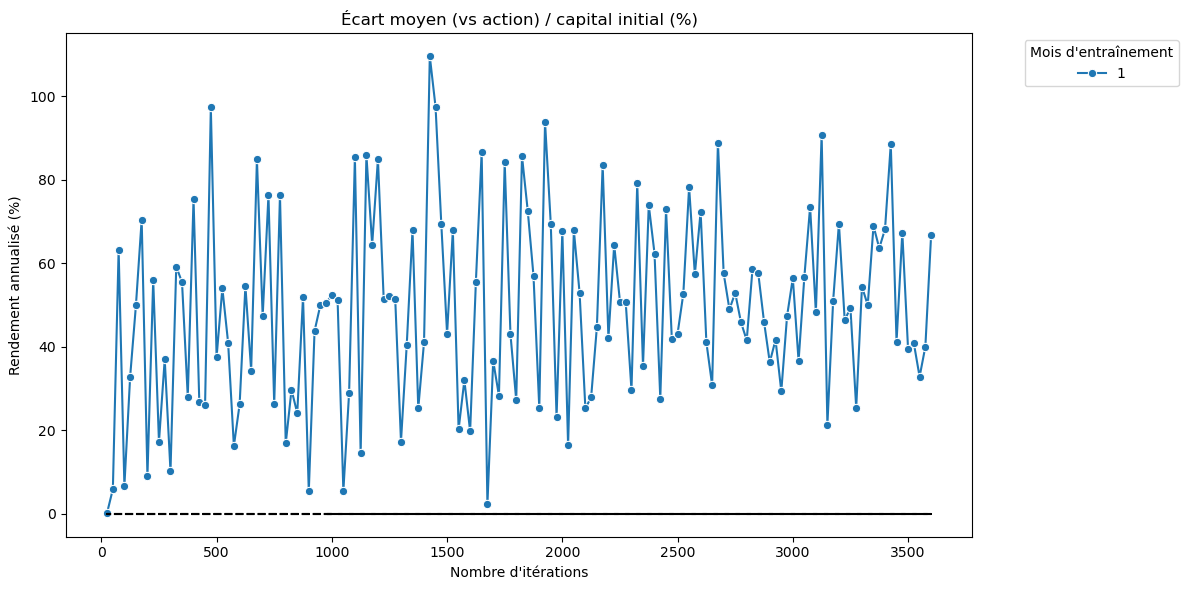

In [43]:
# Courbe : Rendement annualisé selon le nombre d'iterations

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='nb_iterations', y='Écart moyen (vs action) / capital initial (%)', hue='nb_mois_entrainement', palette='tab10', marker='o')
plt.plot(df['nb_iterations'], [0] * len(df['nb_iterations']), color='black', linestyle='--')
plt.title("Écart moyen (vs action) / capital initial (%)")
plt.xlabel("Nombre d'itérations")
plt.ylabel("Rendement annualisé (%)")
plt.legend(title="Mois d'entraînement", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Interprétation du graphique

- On constate que l’écart moyen reste **majoritairement positif**, signe que le modèle bat régulièrement la stratégie passive.
- Il n’y a pas de tendance linéaire claire (ex. croissance continue), mais à partir de **1000–1500 itérations**, on observe une certaine **stabilisation autour de 50–70 %**, avec des pics encore présents.
- Cela indique que **l’augmentation du nombre d’itérations permet en moyenne de maintenir une surperformance**, bien que **la variabilité reste importante** même au-delà de 3000 itérations.
- La ligne noire en pointillés représente la base de référence (écart nul avec le buy and hold).

### Analyse par tranche d’itérations

Pour compléter la visualisation précédente, nous regroupons maintenant les résultats par **tranches de nombre d’itérations** (par exemple 0–300, 300–600, etc.).  
Cela permet de **lisser la variabilité locale** et d'observer les **tendances générales** plus clairement.

Chaque barre représente la **moyenne de l’écart moyen (vs buy and hold)** sur la tranche correspondante, accompagnée de son **écart type**.

C:\Users\selim\AppData\Local\Temp\ipykernel_27424\3800946236.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df.groupby('tranche_iter')[colonne].agg(['mean', 'std']).reset_index()


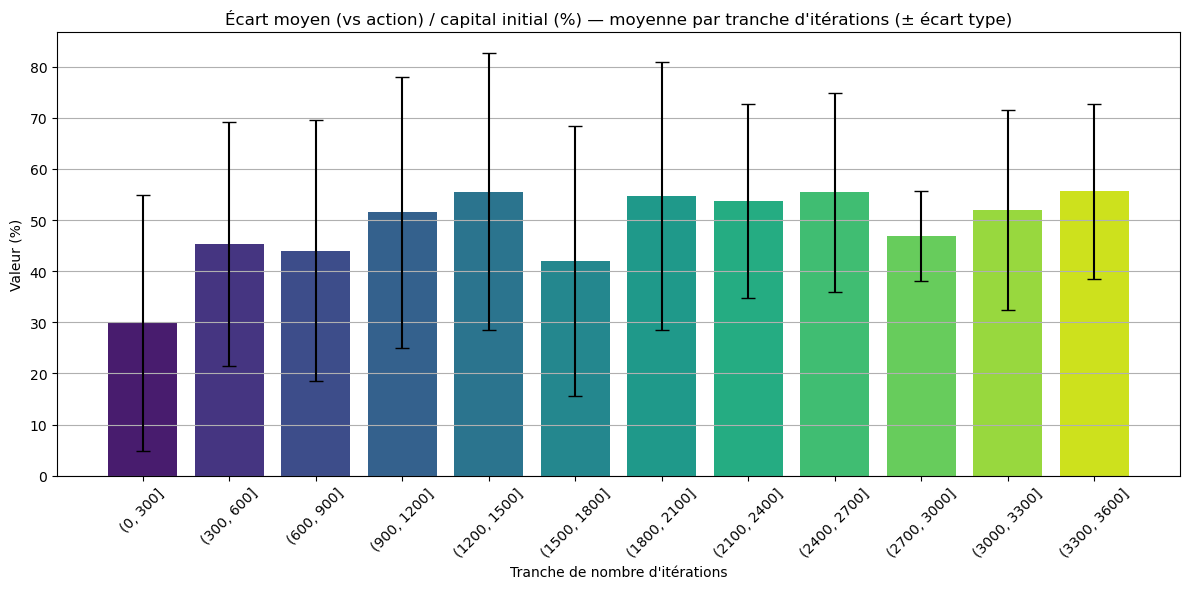

In [44]:
bin_size = 300
max_iter = df['nb_iterations'].max()
bins = np.arange(0, max_iter + bin_size, bin_size)
df['tranche_iter'] = pd.cut(df['nb_iterations'], bins=bins)

# Choisir la colonne à analyser
colonne = 'Écart moyen (vs action) / capital initial (%)'

# Grouper et calculer la moyenne + écart-type
df_grouped = df.groupby('tranche_iter')[colonne].agg(['mean', 'std']).reset_index()
df_grouped = df_grouped.dropna()  # Supprimer les lignes avec NaN

# Création du barplot
labels = df_grouped['tranche_iter'].astype(str)
moyennes = df_grouped['mean']
erreurs = df_grouped['std']
plt.figure(figsize=(12, 6))
plt.bar(labels, moyennes, yerr=erreurs, capsize=5, color=sns.color_palette("viridis", len(moyennes)))
plt.xticks(rotation=45)
plt.title(f"{colonne} — moyenne par tranche d'itérations (± écart type)")
plt.xlabel("Tranche de nombre d'itérations")
plt.ylabel("Valeur (%)")
plt.tight_layout()
plt.grid(axis='y')
plt.show()


### Interprétation du barplot

- Une tendance générale à la **hausse de la surperformance** est visible jusqu’à environ **1500–1800 itérations**.
- Ensuite, les performances moyennes semblent **se stabiliser autour de 50–55 %**, avec une variabilité toujours importante.
- Les tranches les plus basses (< 300 itérations) montrent des performances **nettement inférieures**, ce qui suggère que le modèle n’est pas encore suffisamment entraîné.
- À partir de 900–1200 itérations, **l’amélioration devient significative**, et le gain semble se maintenir.
- L’**écart type reste élevé**, ce qui confirme que malgré la hausse des itérations, **la volatilité des résultats persiste** même si elle diminue un peu à partir de 2100-2400. Cela peut être dû à l’influence des paramètres aléatoires ou à la diversité des hyperparamètres menant à différentes solutions optimales.

---

Cette analyse par tranche permet de conclure que **au-delà de 1000 itérations, le modèle atteint un niveau de surperformance intéressant**, mais que l’effet de convergence reste **partiel**, la variabilité étant toujours présente.